In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, TargetEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from utils.data_transform import *
from utils.visuals import *
from utils.test_menager import *

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
filterwarnings("ignore")

In [2]:
file_path = os.path.join("data", "Train_nyOWmfK.csv")
data = pd.read_csv(file_path, encoding = "ISO-8859–1")

In [3]:
data.head(3)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0


# Happy Customer Bank Dataset

## Data exploration

The data was collected over a three-month period in 2015.

The dataset includes **26 columns** and **87 020 entries**.


It consists of:
* 13 numerical features
	* 11 continous
    * 2 binary (LoggedIn, **Disbursed - target variable**)
* 13 object-type features


There are 11 features in which missing values occur.

The **ID** column contains unique values for each sample and cannot be used for prediction.
The **LoggedIn** column is for problem understanding purposes and cannot be used for prediction.

The meaning of **Var1**, **Var2**, **Var4**, **Var5** and **Source** is unknown.

### Missing values

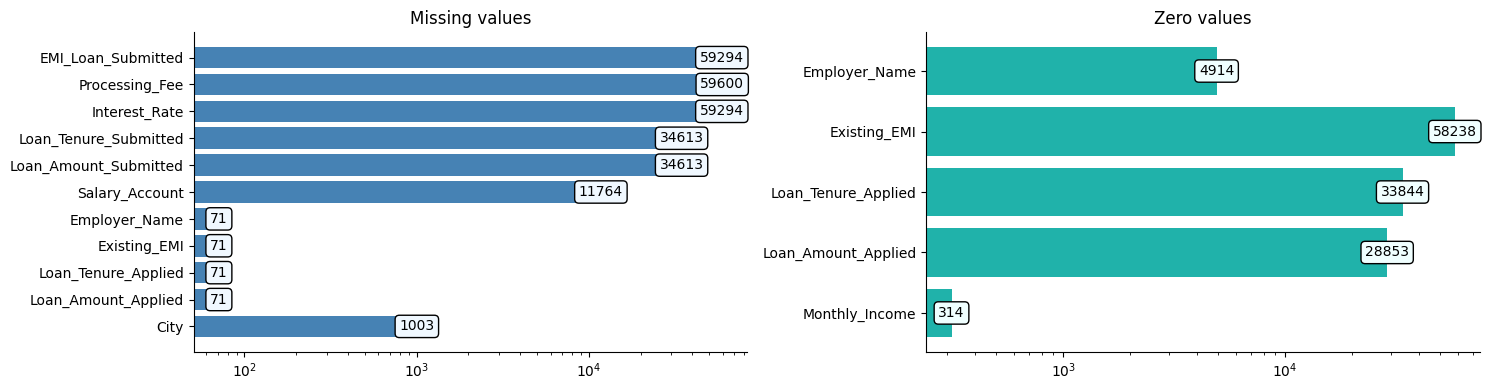

In [4]:
missings_plot(data)

#### There are many NaN and zero values in the dataset. The following assumptions were made:

* At least the majority of missing values are not random.
* **As seen above, there are corresponding missing values in three columns sets**, which may reflect the proccesing of successive stages of the loan apliccation procedure. It's not that all of them had to be completed to receive a loan, although the percentage of disbursements among samples without missing values is higher.
* Numerous zero values in some features can be considered as additional missing values (**Loan_Amount_Applied**, **Loan_Tenure_Applied**, **Employer_Name**).
* **Existing_EMI**: most clients do not have debts.
* **Monthly_Income**: it's possible that some clents do not have a steady income.
* The missing values in **City** column may indicate a lack of a permanent place of residence.
* The missing values in **Salary_Account** column may indicate the absence of a bank account, but they could also result from carelessness during filling application.
  

### Categorical variables

In [5]:
data.describe(include = ['O'])

,ID,Gender,City,DOB,Lead_Creation_Date,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,87020,87020,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,11345,92,43567,57,2,19,2,2,7,30
top,ID000002C20,Male,Delhi,11-Nov-80,03-Jul-15,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,306,2315,4914,17695,56481,59294,67530,64316,37280,38567


There are 13 categorical features:

* 2 with **dates** (DOB, Lead_Creation_Date)
* 7 categorical with **multiple levels** (ID, City, Employer_Name, Salary_Account, Var1, Var2, Source)
* 4 **binary** categorical (Gender, Mobile_Verified, Filled_Form, Device_Type)

As seen below, multicategorical features have rare values that should be aggregated.

In [6]:
data["City"].value_counts().reset_index()

,City,count
0,Delhi,12527
1,Bengaluru,10824
2,Mumbai,10795
3,Hyderabad,7272
4,Chennai,6916
...,...,...
692,Lalitpur,1
693,Kandhamal,1
694,Sawai Madhopur,1
695,Munger,1


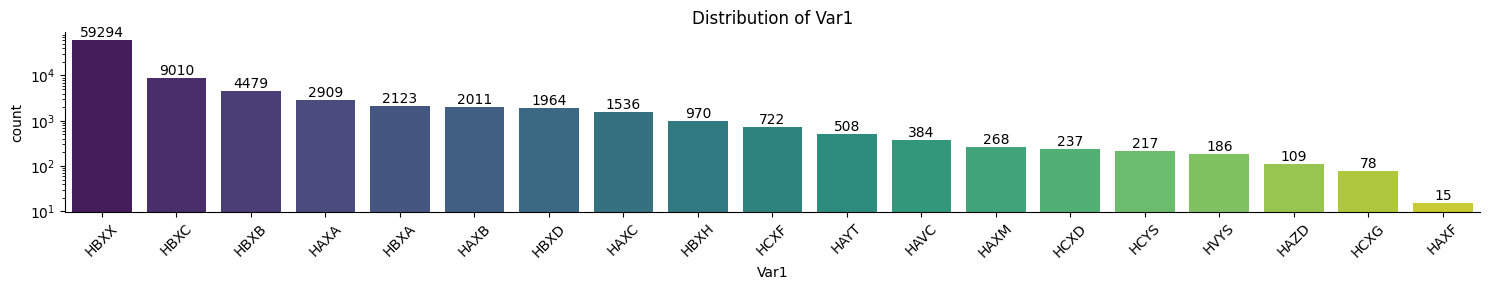

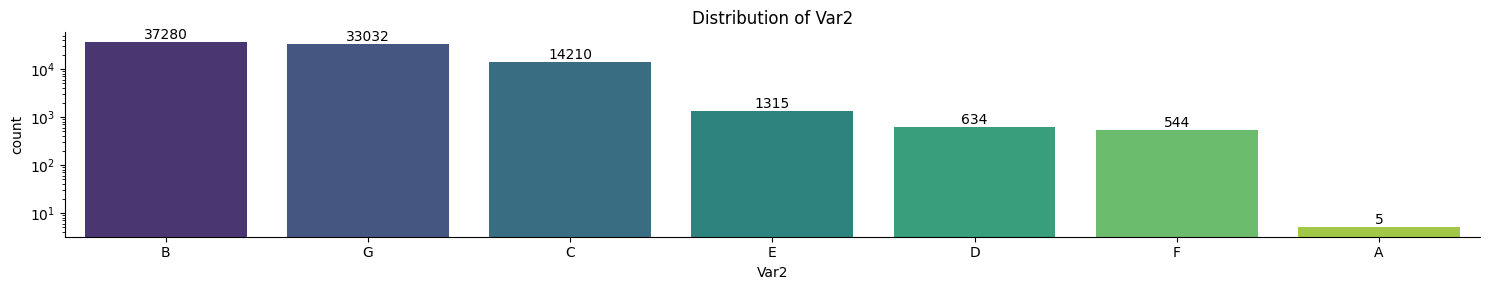

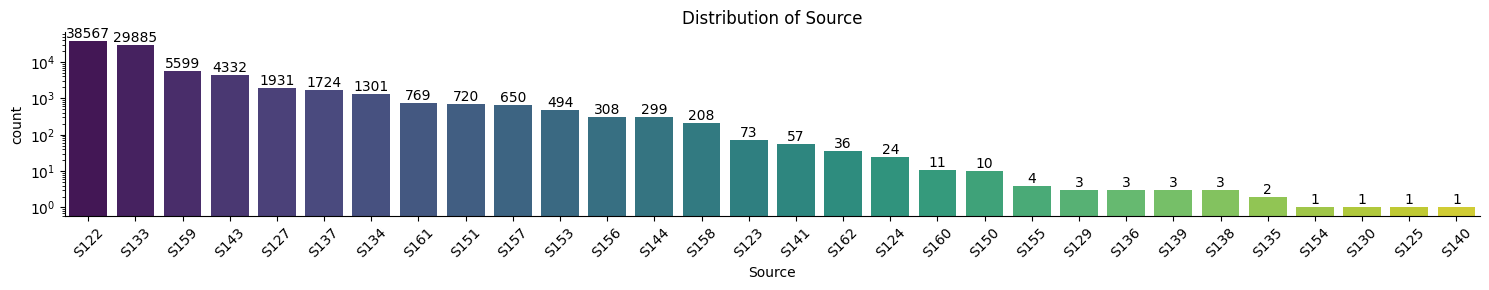

In [7]:
countplots("Var1", "Var2", "Source", data = data)

### Numerical variables

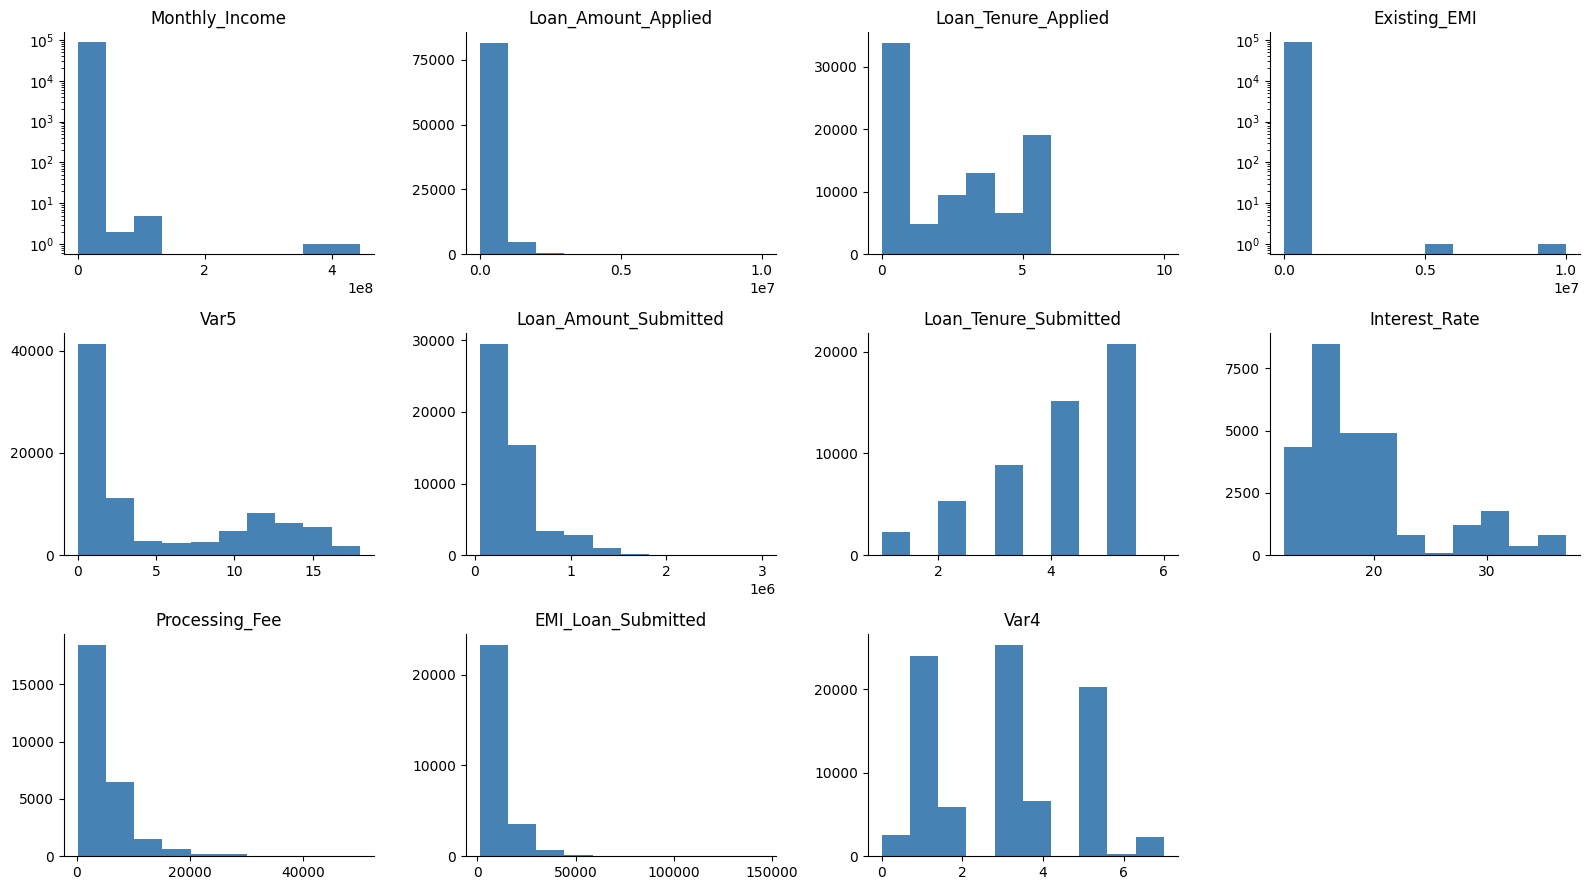

In [8]:
histplots_grid(3, 4, data)

There are 11 continous features.

As seen above, the features display different distributions and varying value ranges. It will be explored the option of applying transformations to bring these values closer to a normal distribution or scale them, especially when using methods that require such transformations. However, these transformations are not necessary when using tree-based algorithms.

### Target variable

In [9]:
data.Disbursed.value_counts(normalize=True).round(4)

Disbursed
0    0.9854
1    0.0146
Name: proportion, dtype: float64

In this dataset, highly imbalanced classes are present. 
The following strategies were adopted to address this issue:

* stratified train_test_split
* stratified KFold for cross-validation
* increasing the weight of the minority class or resampling within balanced ensemble models

# Experiments

## First data version data_v1

* **ID**, **Lead_Creation_Date**, **Device_Type**, **Salary_Account** columns removed, since their use in prediction doesn't make logical sense.

* **City** column cransformation: from 698 to 2 categories: Y/N ([cities with over 1 million residents and smaller](https://www.loomsolar.com/blogs/collections/list-of-cities-in-india)), missing values left unchanged. Renamed to **Is_Big_City**. 

* **Employer_Name** column transformation: into 1/0, as it was considered that the employer name is not important, but the fact of providing or not providing this information during the application process may be significant. Renamed to **Employer_Provided**.

* **DOB** column cransformation: from date of birth to year of birth, which is analogous to using age, as the data was collected in the same year. Renamed to **Year_Of_Birth**.

* **Var1, Var2, Source** - rare values aggregated as "Others".

* Numerical variables and missing values left unchanged, except filling 71 corresposponding missings in **Loan_Amount_Applied, Loan_Tenure_Applied, Existing_EMI** with 0.

In [4]:
X, y = data_preparing_v1(data)

X.shape, y.shape

((87020, 20), (87020,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)
X_train.head(3)

,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Var2,Source,Var4
26733,Female,Delhi,50000,02-Apr-76,1000000.0,5.0,0.0,SCHOLASTIC INDIA PVT LTD,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,B,S133,3
81500,Female,Chennai,17475,19-Jun-88,200000.0,3.0,4732.0,PRACTO TECHNOLOGIES PVT LTD,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,G,S122,3
81659,Female,Noida,52000,15-Mar-62,0.0,0.0,0.0,NEW OKHLA INDUSTRIAL DEVELOPMENT AUTHORITY,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,G,S122,3


**The main goal of this stage is to track the behavior of models with different types of basic transformations and select the models that achieve the best results.**

Tree-based ensembles were applied:

* BaggingClassifier,
* HistGradientBoostingClassifier,
* RandomForestClassifier,
* BalancedBaggingClassifier with RandomUnderSampler,
* BalancedBaggingClassifier with RandomOverSampler,
* EasyEnsembleClassifier,
* BalancedRandomForestClassifier
 
in their default or slightly modified parameter configurations.

The tests were conducted using **stratified, shuffled 5 fold cross-validation on the training set** (random_state = 42).

In [7]:
models = [BaggingClassifier(n_estimators = 100, 
                            random_state = 42, n_jobs = -1),
          BaggingClassifier(estimator = 
                            DecisionTreeClassifier(class_weight = {1:100},
                                                   min_samples_leaf = 5,
                                                   random_state = 42),
                            n_estimators = 100,
                            max_samples = 0.5,
                            random_state = 42, n_jobs = -1),
          HistGradientBoostingClassifier(random_state = 42),
          HistGradientBoostingClassifier(class_weight = {1:20},
                                         min_samples_leaf = 50,
                                         random_state = 42),
          RandomForestClassifier(min_samples_leaf = 5,
                                 random_state = 42, n_jobs = -1),
          RandomForestClassifier(class_weight = {1:100}, 
                                 min_samples_leaf = 20,
                                 max_samples = 0.5,
                                 random_state = 42, n_jobs = -1),
          BalancedBaggingClassifier(n_estimators = 100,
                                    sampler = RandomUnderSampler(random_state = 42),
                                    random_state = 42, n_jobs = -1),
          BalancedBaggingClassifier(n_estimators = 100,
                                    max_samples = 0.5,
                                    sampler = RandomUnderSampler(random_state = 42),
                                    replacement = True,
                                    random_state = 42, n_jobs = -1),
          BalancedBaggingClassifier(n_estimators = 100,
                                    sampler = RandomOverSampler(random_state = 42),
                                    random_state = 42, n_jobs = -1),
          EasyEnsembleClassifier(n_estimators = 50, 
                                 random_state = 42, n_jobs = -1),
          EasyEnsembleClassifier(n_estimators = 100,
                                 random_state = 42, n_jobs = -1, 
                                 replacement = True),
          BalancedRandomForestClassifier(random_state = 42, n_jobs = -1, 
                                         replacement = True, sampling_strategy="auto"),
          BalancedRandomForestClassifier(max_samples = 0.5,
                                         max_features = 0.3,
                                         random_state = 42, n_jobs = -1, 
                                         replacement = True, sampling_strategy="auto")
         ]

### Missing values imputation tests

In this section, tests were conducted with various methods of handling missing values. The following were tested:

* imputation with an out-of-range value (-1) by **Simple Imputer**,
* **KNN Imputer** (preceded by scaling for better performance),
* experimental **Iterative Imputer** (preceded by power transformation for better performance),
* **the lack of imputation** was checked for models that support it.

**One-hot encoding** was applied to categorical features.

In [8]:
num_preprocessors = [
            ("SimpleImputer",
             SimpleImputer(strategy = "constant", 
                           fill_value = -1)), 
            ("KNNImputer",
             make_pipeline(MinMaxScaler(),
                           KNNImputer())), 
            ("IterativeImputer",
             make_pipeline(PowerTransformer(),
                           IterativeImputer(sample_posterior = True,
                                            random_state = 42)))
]

results_non_imp = collect_tests_results(X_train, y_train,
                                        test = "imputation",
                                        models = models,
                                        preprocessors = None)

results_with_imp = collect_tests_results(X_train, y_train,
                                        test = "imputation",
                                        models = models,
                                        preprocessors = num_preprocessors)

results_imp = create_results_dataframe(results_non_imp, results_with_imp)
results_imp.to_csv("data/data_v1_results_imputation.csv", index = False)

In [9]:
# results_imp = pd.read_csv("data/data_v1_results_imputation.csv")
results_imp.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Imputation,Time[s]
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8463,none,1.54
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: 0.5",0.8448,SimpleImputer,1.36
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8447,SimpleImputer,1.72
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8442,IterativeImputer,5.86
BalancedBagging_UnderSampling,"n_estimators: 100, max_samples: 0.5",0.8434,SimpleImputer,1.57


In [10]:
summarize_results(results_imp, column_to_group_by = "Imputation")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Imputation,,,,,,,
none,7,0.824500,0.789100,0.846300,7.030000,1.440000,31.250000
SimpleImputer,13,0.825700,0.763200,0.844800,8.450000,1.360000,40.150000
IterativeImputer,13,0.823300,0.766800,0.844200,13.910000,5.630000,50.920000
KNNImputer,13,0.822300,0.758300,0.842400,298.620000,289.720000,325.320000


There is no significant difference in imputation performance among different imputers, but the execution time for KNNImputer is unacceptable. The best results were achieved by HistGradientBoostingClf without imputation and with Simple Imputer, as well as BalancedRandomForestClf with Simple Imputer.

### Category encoders tests

In this section, tests were conducted with various methods of encoding categorical features. The following were tested:

* **One-Hot Encoder**,
* **Ordinal Encoder**,
* **Target Encoder**,
* **Frequency Encoder** (custom encoder, encoding features based on their frequency of occurrence).

Missing values in numerical columns were filled with the vallue -1 using Simple Imputer.
For the categorical column Is_Big_City, categorical encoders will encode the missing values as a separate category.

In [12]:
cat_preprocessors = [
    OneHotEncoder(),
    OrdinalEncoder(encoded_missing_value = -1),
    TargetEncoder(random_state=42),
    FrequencyEncoder()
]

In [13]:
results_enc = collect_tests_results(X_train, y_train,
                                    test = "cat_encoding",
                                    models = models,
                                    preprocessors = cat_preprocessors)


results_enc = create_results_dataframe(results_enc)
results_enc.to_csv("data/data_v1_results_cat_encoding.csv", index = False)

In [9]:
# results_enc = pd.read_csv("data/data_v1_results_cat_encoding.csv")
results_enc.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Encoder,Time[s]
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8458,TargetEncoder,1.08
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: 0.5",0.8448,OneHotEncoder,1.24
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8447,OneHotEncoder,1.66
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: 0.5",0.8444,TargetEncoder,1.34
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None",0.8444,TargetEncoder,1.31


In [10]:
summarize_results(results_enc, column_to_group_by = "Encoder")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Encoder,,,,,,,
TargetEncoder,13,0.827800,0.776000,0.845800,6.400000,0.960000,24.590000
OneHotEncoder,13,0.825700,0.763200,0.844800,8.240000,1.240000,37.930000
FrequencyEncoder,13,0.823000,0.757800,0.843500,6.170000,1.070000,24.720000
OrdinalEncoder,13,0.822600,0.754700,0.840800,5.870000,0.870000,24.610000


The method of encoding categorical features did not significantly affect the results, but the best results were achieved using target and one-hot encoding.

### Feature selection tests

While there are only 20 variables, the meaning of 5 of them is unknown, which is why such a test was conducted.

Feature selection based on importance weights was applied.

Missing values in numerical columns were filled with the value -1 using Simple Imputer.
For the categorical columns, Target Encoder were used.

#### Estimator optimization

After optimization using GridSearchCV, **Random Forest Classifier** with best parameters was used as the feature selection estimator.

In [9]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {"model__class_weight": [{1:75}, {1:100}],
              "model__n_estimators": [100, 200],
              "model__min_samples_leaf": [5, 20, 50],
              "model__max_features": [0.3, 0.5, 0.7],
              "model__max_samples": [0.3, 0.5, 0.7]}

best_params_and_score, best_estimator = collect_tests_results(X_train, y_train,
                                                              test = "searching_params",
                                                              grid_search = (model, param_grid))

In [10]:
best_forest = best_estimator.steps[1][1]
best_params_and_score

{'model__class_weight': {1: 100},
 'model__max_features': 0.5,
 'model__max_samples': 0.5,
 'model__min_samples_leaf': 50,
 'model__n_estimators': 200,
 'best_auc_score': 0.8456}

#### Feature selection

In [11]:
results_sel = collect_tests_results(X_train, y_train,
                                    test = "feature_selection",
                                    feat_sel_estimator = best_forest,
                                    models = models)

results_sel = create_results_dataframe(results_sel)
results_sel.to_csv("data/data_v1_results_feature_selection.csv", index = False)

In [12]:
# results_sel = pd.read_csv("data/data_v1_results_feature_selection.csv")
results_sel.set_index("Model").sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Threshold,Selected[%],Rejected[idx],Time[s]
Model,,,,,,
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8458,0.010,100.0,[],4.83
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8455,0.016,90.0,"[8, 17]",4.65
HistGradientBoostingClassifier,"class_weight: {1: 20}, min_samples_leaf: 50",0.8445,0.015,95.0,[17],4.59
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: None",0.8444,0.010,100.0,[],4.99
BalancedRandomForestClassifier,"n_estimators: 100, class_weight: None, min_samples_leaf: 1, max_samples: 0.5",0.8444,0.010,100.0,[],5.06


In [13]:
summarize_results(results_sel, column_to_group_by = "Selected[%]")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Selected[%],,,,,,,
100.000000,13,0.827800,0.776000,0.845800,9.900000,4.760000,28.030000
90.000000,13,0.826800,0.768700,0.845500,9.630000,4.590000,26.520000
95.000000,13,0.827700,0.776500,0.844500,9.730000,4.590000,26.720000
80.000000,13,0.826400,0.766100,0.843600,9.410000,4.700000,26.450000
65.000000,13,0.827100,0.771200,0.843500,9.180000,4.650000,25.870000
85.000000,13,0.826400,0.769000,0.842500,9.470000,4.600000,26.510000
60.000000,13,0.823800,0.766400,0.841200,8.850000,4.570000,25.660000
50.000000,13,0.821100,0.761600,0.837500,8.420000,4.530000,25.390000


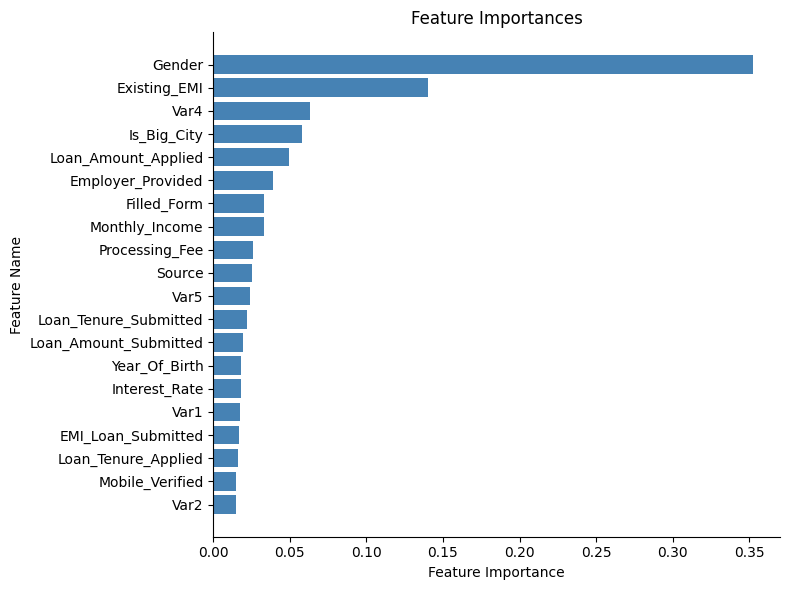

In [14]:
feature_importance_plot(best_forest.feature_importances_, 
                        X.columns)

The best results were achieved by retaining 100% of the features.

However, it was determined which features are the least important, and it was found that removing them does not significantly impact the results. Very high scores (above 84) were achieved even when only 60% of the features were selected. So it could also be checked if, after removing some columns, but with different hyperparameters for the models, the results will be better.

In [9]:
# results_imp = pd.read_csv("data/data_v1_results_imputation.csv")
# results_enc = pd.read_csv("data/data_v1_results_cat_encoding.csv")
# results_sel = pd.read_csv("data/data_v1_results_feature_selection.csv")

all_models_results = create_results_dataframe(results_imp[["Model", "ROC_AUC", "Time[s]"]],
                                              results_enc[["Model", "ROC_AUC", "Time[s]"]],
                                              results_sel[["Model", "ROC_AUC", "Time[s]"]])

summarize_results(all_models_results, column_to_group_by = "Model")

,count,mean_roc_auc,min_roc_auc,max_roc_auc,mean_time[s],min_time[s],max_time[s]
Model,,,,,,,
HistGradientBoostingClassifier,32,0.841500,0.836100,0.846300,21.600000,0.870000,296.610000
BalancedRandomForestClassifier,30,0.841400,0.835600,0.844800,23.200000,1.240000,296.900000
BalancedBagging_UnderSampling,32,0.840100,0.835200,0.843500,21.890000,1.090000,292.270000
RandomForestClassifier,30,0.830000,0.817600,0.842200,23.680000,1.430000,296.000000
EasyEnsembleClassifier,30,0.830600,0.827400,0.832600,39.790000,12.370000,314.740000
BaggingClassifier,32,0.796300,0.764100,0.826200,25.320000,3.050000,293.690000
BalancedBagging_OverSampling,16,0.770200,0.754700,0.789100,46.030000,15.690000,325.320000


**A summary of all tests from this phase for the models** can be seen in the table above. For further testing, HistGradientBoostingClf, BalancedRandomForestClf and BalancedBaggingClf with undersampling were chosen, as they consistently provided the highest ROC_AUC scores in all tests, and were also the fastest. The worst results were achieved by BalancedBaggingClf with oversampling.

## Different data transformations and hyperparameters optimization

At this stage, we revert to raw data, and all transformations will be performed solely using transformers within pipelines (only insignificant columns were removed). The aim is to find the most advantageous data transformation.

In [4]:
X, y = data_preparing_v2(data)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((69616, 20), (69616,), (17404, 20), (17404,))

In [5]:
X_train.head(3)

,Gender,City,Monthly_Income,DOB,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Var2,Source,Var4
26733,Female,Delhi,50000,02-Apr-76,1000000.0,5.0,0.0,SCHOLASTIC INDIA PVT LTD,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,B,S133,3
81500,Female,Chennai,17475,19-Jun-88,200000.0,3.0,4732.0,PRACTO TECHNOLOGIES PVT LTD,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,G,S122,3
81659,Female,Noida,52000,15-Mar-62,0.0,0.0,0.0,NEW OKHLA INDUSTRIAL DEVELOPMENT AUTHORITY,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,G,S122,3


In [8]:
from sklearn import set_config
set_config(transform_output="pandas")

num_features = X.select_dtypes("number").columns
cat_features = X.select_dtypes("object").columns

union = FeatureUnion([
    ("cat_pipe", Pipeline([
        ("grouper", ColumnTransformer([
            ("city", FrequencyEncoder(group_only=True), ["City"]),
            ("vars", FrequencyEncoder(group_only=True), ["Var1", "Var2", "Source"]),
            ("specials", "drop", ["DOB", "Employer_Name"])
        ], remainder="passthrough")),
        ("encoder", TargetEncoder(random_state=42))])),
    ("specials", ColumnTransformer([
        ("zero_one", ZeroOneEncoder(), ["Employer_Name"]),
        ("date", DateEncoder(), "DOB")]))
])
num_pipe = make_pipeline(PowerTransformer(), MixedImputer())

preprocessor = make_column_transformer(
    (num_pipe, num_features),
    (union, cat_features)
)

pipeline = Pipeline([("preprocessor", preprocessor), ("remover", ColumnRemover()), ("model", HistGradientBoostingClassifier(random_state=42, class_weight={1:20}, min_samples_leaf=50))])

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('mixedimputer',
                                                                   MixedImputer())]),
                                                  Index(['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied',
       'Existing_EMI', 'Var5', 'Loan_Amount_Submitted',
       'Loan_Tenure_Submitted', 'Interest_Rate', 'Processing_Fee',
       'EMI_Loan_Sub...
                                                                                  ColumnTransformer(transformers=[('zero_one',
                                                                                                                   ZeroOneEncoder(),
                                                                                                                   ['Employer_Name']),
                                                                                                                  ('date',
                                                                                                                   DateEncoder(),
                                                                                                                   'DOB')]))]),
                                                  Index(['Gender', 'City', 'DOB', 'Employer_Name', 'Mobile_Verified', 'Var1',
       'Filled_Form', 'Var2', 'Source'],
      dtype='object'))])),
                ('remover', ColumnRemover()),
                ('model',
                 HistGradientBoostingClassifier(class_weight={1: 20},
                                                min_samples_leaf=50,
                                                random_state=42))])

In [52]:
getattr(optimizer.best_estimator_, "model")

AttributeError: 'Pipeline' object has no attribute 'model'